In [25]:
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

Notebook goal is to model gridcells as a twisted torus using velocity as an input, using equations from Guanella and Verschure 2007

**Reference**
\
\
$N:$ Number of neurons
\
$N_{x}:$ Width
\
$N_{y}:$ Height
\
$A:$ Activity matrix of shape $x$ by $y$
\
$I:$ Intensity parameter, defining the overall strength of the synapses
\
$\sigma:$ Regulates the size of the Gaussian
\
$T:$ Shift parameter determining excitatory and inhibitory zones
\
$\alpha:$ The gain (distance between receptive fields)
\
$\beta:$ The bias (angle of receptive fields) $[0, \pi/3]$

In [14]:
#Only Ny needs to be defined, but writing out for clarity
#Nx = Ny + 1, N = Nx * Ny
Ny = 9
Nx = 10
N = 90

Initialize neuron activity randomly distributed between $0$ and $1/\sqrt{N}$

**Activity Eqs.**
\
\
$B_{i}(t+1) = A_{i}(t) + \sum \limits _{j=1}^{N}A_{j}(t)w_{ji}$ 
\
$A_{i}(t+1) = B_{i}(t+1) + \tau\Bigg(\frac{B_{i}(t+1)}{<B_{j}(t+1)>_{j=1}^{N}}-B_{i}(t+1)\Bigg)$
\
\
Function $< . >_{j=1}^{N}$ is the mean over the cells of the network, used to ensure stability \
\
Therefore $<B_{j}(t+1)>_{j=1}^{N}$ is an external cell that keeps things stable \
\
$A_{i}(t+1) = 0$ when $A_{i}(t+1)$ is smaller than 0 \
\
\
**Synapse Eqs.**
\
\
$w_{ij} = I\exp{(-\frac{||c_{i}-c_{j}||_{tri}^2}{\sigma^2})} - T$
\
\
*Where $c_{i} = (c_{ix},c_{iy})$ is the position of cell $i$, $c_{ix} = (i_{x} + 0.5)/N_{x}$ and $c_{iy} = \frac{\sqrt{3}}{2}(i_{y} + 0.5)/N_{y}$ 
\
\
$dist_{tri}(c_{i},c_{j}) := ||c_{1}-c_{2}||_{tri} = \min_{j=1}^{7}||c_{1}-c_{2}+s_{j}||$




$s_{1} := (0,0),$
\
\
$s_{2} := (-0.5,\frac{\sqrt{3}}{2}),$
\
\
$s_{3} := (-0.5,-\frac{\sqrt{3}}{2}),$
\
\
$s_{4} := (0.5,\frac{\sqrt{3}}{2}),$
\
\
$s_{5} := (0.5,-\frac{\sqrt{3}}{2})$
\
\
$s_{6} := (-1,0),$
\
\
$s_{7} := (1,0),$

*Equation changed slightly from paper to adjust for indices starting at 0

**Modulation Eqs**
\
\
$R_{\beta} = \begin{pmatrix} \cos(\beta) & -\sin(\beta) \\ \sin(\beta) & \cos(\beta) \end{pmatrix} = \cos(\beta) + i\sin(\beta)$

$w_{ij}(t+1) = I\exp\bigg(-\frac{||c_{i}-c_{j}+\alpha R_{\beta}v(t)||^2_{tri}}{\sigma^2}\bigg) - T$

To calculate activity $A$, we need the weight matrix $W$. To calculate the weights, we need the receptive field locations $(c_{x},c_{y})$, which are stored in the matrix $C$

$i_{x}, i_{y}$ are indices in the range $0$ to $N_{x}, N_{y}$, whilst $i$ is the index in range $0$ to $N$ 

**Exploration Start**
\
\
To start, let's go through the equations one by one, following them without the use of matrices. This will be less efficient, but will allow us to make sure everthing is working.
\
\
We'll begin by setting up the coordinate matrix $C$, which stores the rectangular locations of the cells' receptive fields. I say rectangular rather than triangular because it will be 'twisted' by the $tri$ distribution later on

In [15]:
#x and y coords
Cx = (np.arange(Nx)+(0.5))/Nx
Cy = ((np.arange(Ny)+(0.5))/Ny)*np.sqrt(3)/2

#Creating a mesh, so we end up with Nx by Ny coords (N)
Tx, Ty = np.asarray(np.meshgrid(Cx, Cy))

#Combining and adding a complex j (i) component to represent the y-coord. Make things easier later on if we don't make this into a 2d array
C = (Tx+1j * Ty).reshape(-1,1)

In [16]:
#Printing first 5 values
print(C[:5])

[[0.05+0.04811252j]
 [0.15+0.04811252j]
 [0.25+0.04811252j]
 [0.35+0.04811252j]
 [0.45+0.04811252j]]


Now we'll compute the initial weights. To do this, we will need to twist the rectangular coordinates using the $tri$ distribution.

In [17]:
#Values for s from paper, used to create triangular tesselation.
S = [ 0+1j*0, -0.5+1j*np.sqrt(3)/2, -0.5+1j*(-np.sqrt(3)/2), 0.5+1j*np.sqrt(3)/2, 0.5+1j*(-np.sqrt(3)/2), -1+1j*0, 1+1j*0]

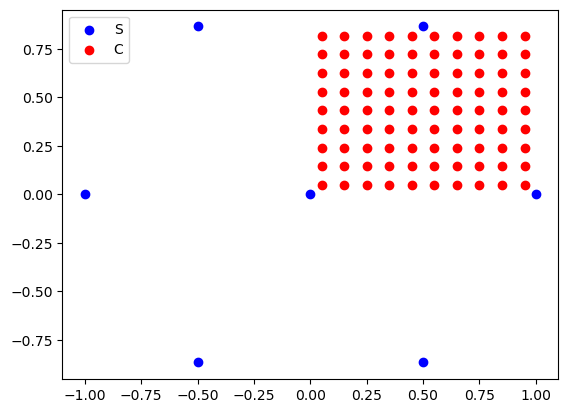

In [18]:
#Plotting for visualization, not needed by actual model

#S coords
sx = [s.real for s in S]
sy = [s.imag for s in S]
#C coords
cx = [c.real for c in C]
cy = [c.imag for c in C]

plt.scatter(sx,sy, color='blue', label='S')
plt.scatter(cx,cy, color='red', label='C')
plt.legend()
plt.show()

By fitting with S (Blue) we can twist C (Red) into a triangular distribution. NOW, we'll actually move onto the weight initialization: both with and without the triangular tesselation

In [19]:
#Empy weight matrix
w = np.zeros((N,N))
#Parameter values taken from paper
I = 0.3
T = 0.05
sigma = 0.24

for i in range(N):
    for j in range(N):
        #dist_tri function
        tri = np.abs(C[i] - C[j])
        for s in S:
            d = np.abs(C[i] - C[j] + s)
            if d < tri:
                tri = d
        w[i][j] = I * np.exp(-(tri**2)/(sigma**2)) - T

#Empy testing weight matrix
w_test = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        #This time, no need for a dist_tri function
        tri = np.abs(C[i] - C[j])
        w_test[i][j] = I * np.exp(-(tri**2)/(sigma**2)) - T

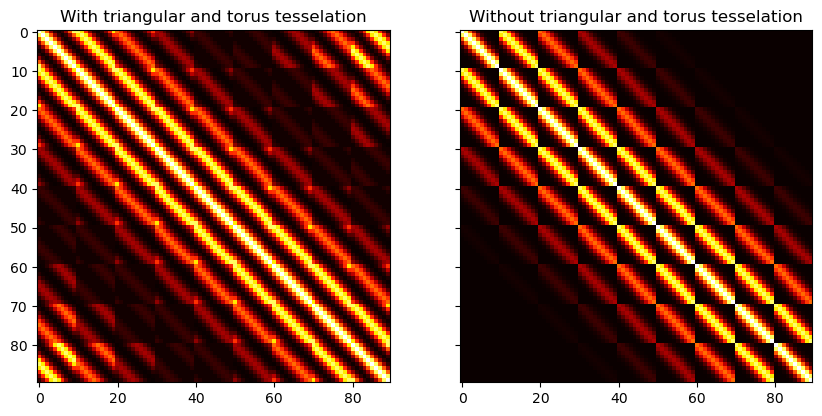

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches((10,10))
ax1.imshow(w, cmap='hot', interpolation='nearest')
ax1.title.set_text("With triangular and torus tesselation")
ax2.imshow(w_test, cmap='hot', interpolation='nearest')
ax2.title.set_text("Without triangular and torus tesselation")
plt.show()

Cool! As you can see, neurons have strong connections to themselves and their neighbors, with those connections steadily weakening the further you get away. 
\
\
With a triangular tesselation, we can see the distribution of connections is much smoother. And, thanks to the torus, neurons on opposite sides are considered neighbors.

Ok! Let's calculate the activity.

In [21]:
#Activity initialized randomly as per paper
def initA(Nx, Ny):
    return np.random.uniform(0, 1/np.sqrt(N), N)

T = 90
A = initA(Nx, Ny)

#Stores A and B at each timestep
At = np.zeros((T, N))
At[0] = A
Bt = np.zeros((T, N))

tau = 0.8

for t in range(T-1):
    for i in range(N):
        #w_ji: weights to neuron i
        Bt[t+1][i] = At[t][i] + At[t]@w[:][i]

        #Divided by mean to maintain stability
        At[t+1][i] = Bt[t+1][i] + tau*((Bt[t+1][i]/np.mean(Bt[t+1])) - Bt[t+1][i])
        if At[t+1][i] < 0:
            At[t+1][i] = 0

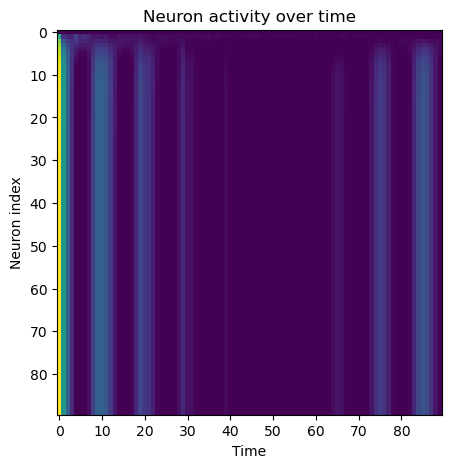

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((5,5))
ax.imshow(At)
ax.title.set_text("Neuron activity over time")
ax.set_ylabel("Neuron index")
ax.set_xlabel("Time")
plt.show()

Sick! It takes a moment (due to B being initialized as zero), but after a few timesteps we can see that Neuron 0 is the most active, followed by its neighbors.

Notice that the activity is constant. This is because we have not implemented any moving agent! So the model assumes we have a velocity of 0: meaning the activity remains at it's starting point.

Let's fix that! To keep things simple, we'll start by simulating an agent moving in a straight line at a constant velocity. 
\
\
We will also ignore gain and bias for now

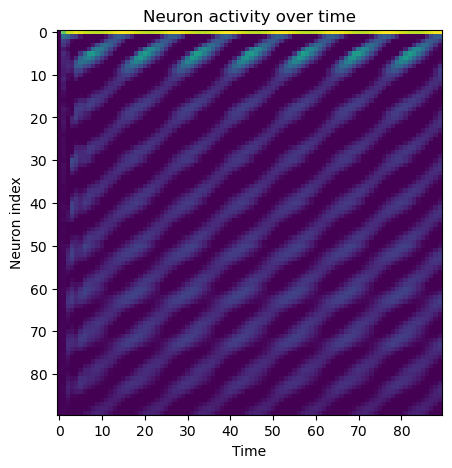

In [19]:
v = 0.25 + 0.25j

#Activity initialized randomly as per paper
def initA(Nx, Ny):
    return np.random.uniform(0, 1/np.sqrt(N), N)

Time = 90
A = initA(Nx, Ny)

#Stores A and B at each timestep
At = np.zeros((Time, N))
At[0] = A
Bt = np.zeros((Time, N))

tau = 0.8

#Empy weight matrix
w = np.zeros((Time,N,N))
#Parameter values taken from paper
I = 0.3
T = 0.05
sigma = 0.24

for t in range(Time-1):
    #Update weights
    for i in range(N):
        for j in range(N):
            #dist_tri function
            tri = np.abs(C[i] - C[j] + v)
            for s in S:
                d = np.abs(C[i] - C[j] + v + s)
                if d < tri:
                    tri = d
            w[t][i][j] = I * np.exp(-(tri**2)/(sigma**2)) - T

    #Update activity
    for i in range(N):

        #w_ji: weights to neuron i
        Bt[t+1][i] = At[t][i] + At[t]@w[t][:][i]

        #Divided by mean to maintain stability
        At[t+1][i] = Bt[t+1][i] + tau*((Bt[t+1][i]/np.mean(Bt[t+1])) - Bt[t+1][i])
        if At[t+1][i] < 0:
            At[t+1][i] = 0

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((5,5))
ax.imshow(At.T)
ax.title.set_text("Neuron activity over time")
ax.set_ylabel("Neuron index")
ax.set_xlabel("Time")
plt.show()

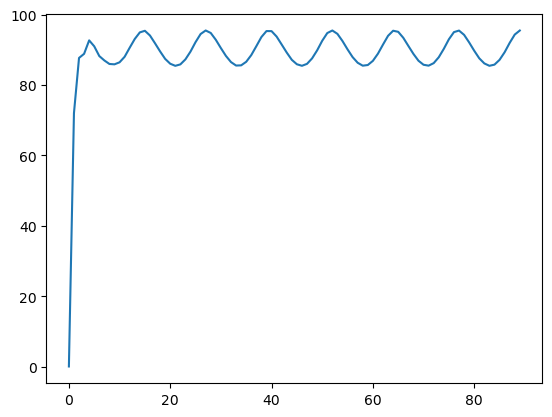

In [48]:
plt.plot(At[:,0])

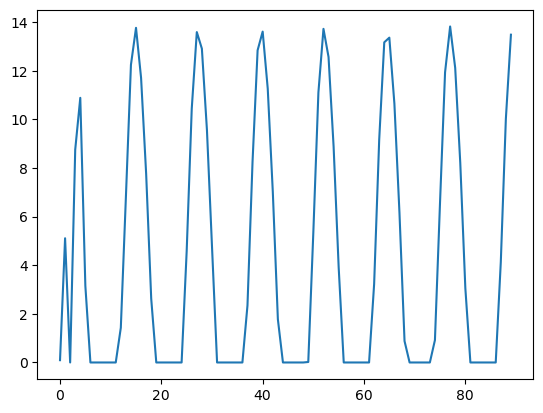

In [55]:
plt.plot(At[:,21])

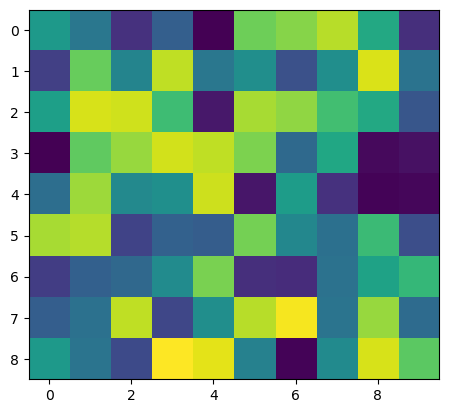

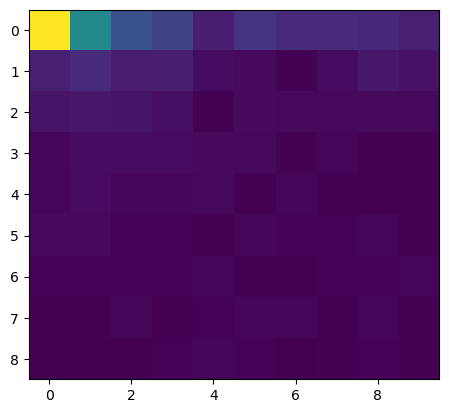

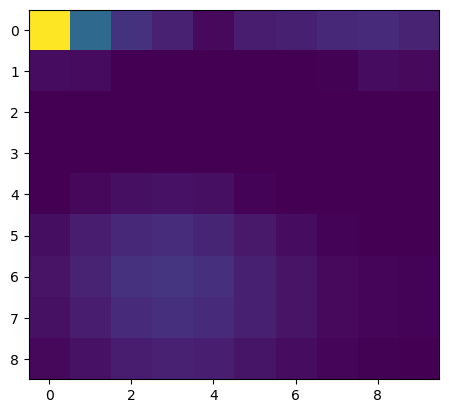

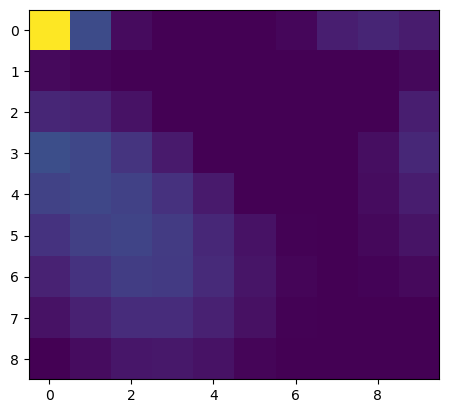

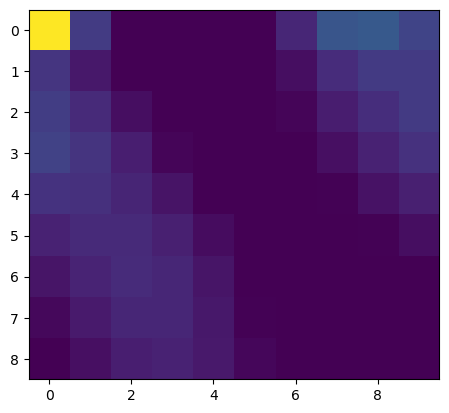

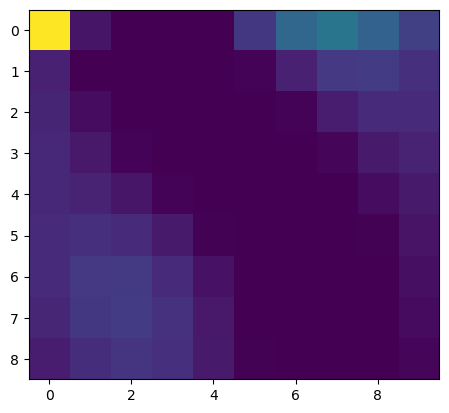

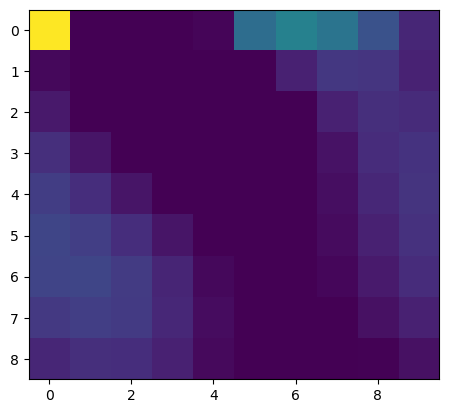

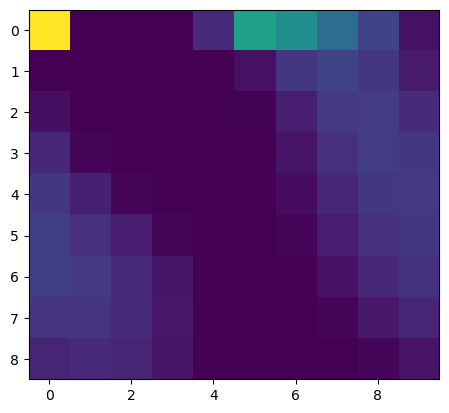

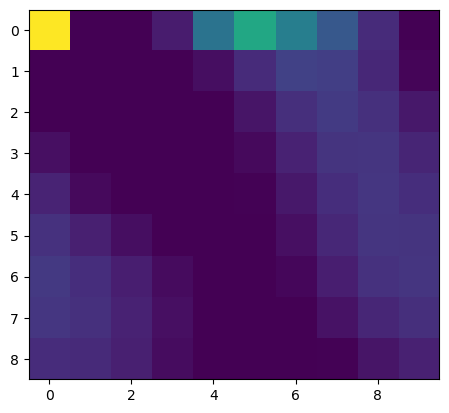

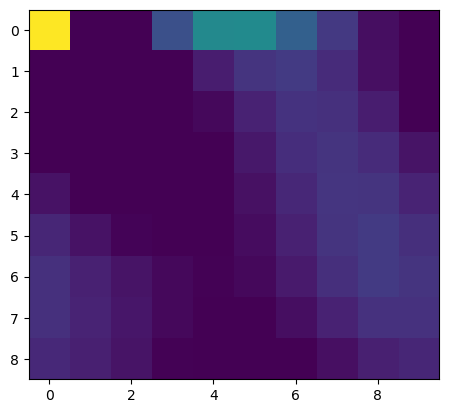

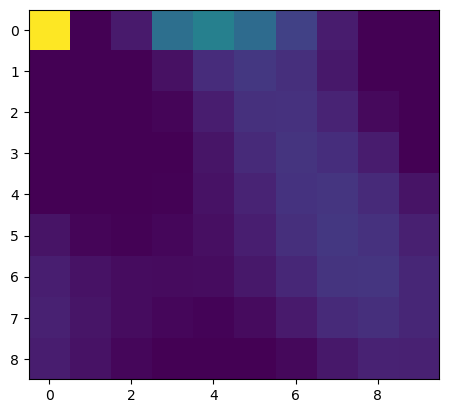

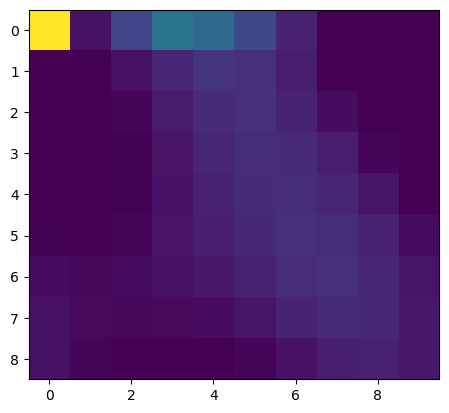

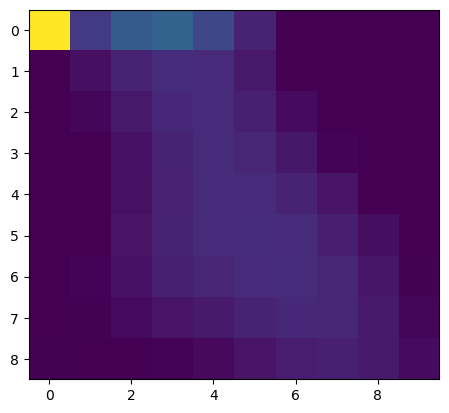

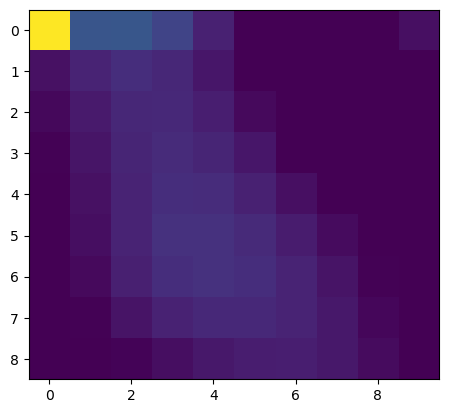

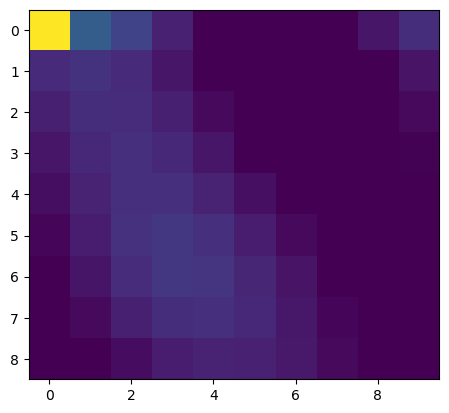

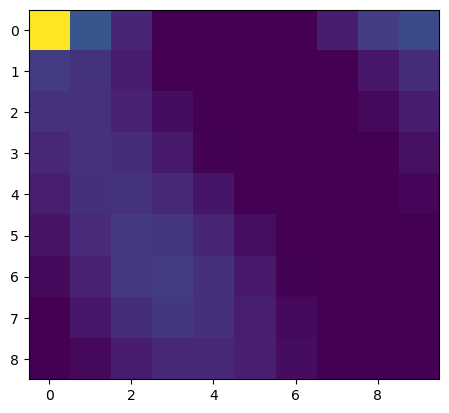

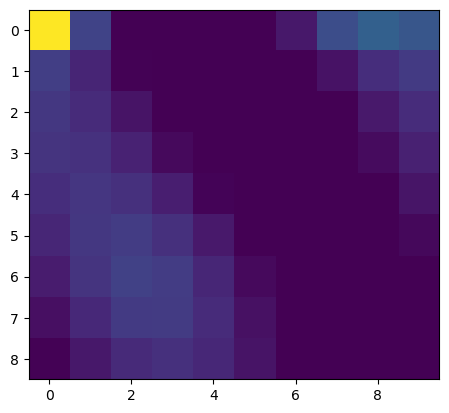

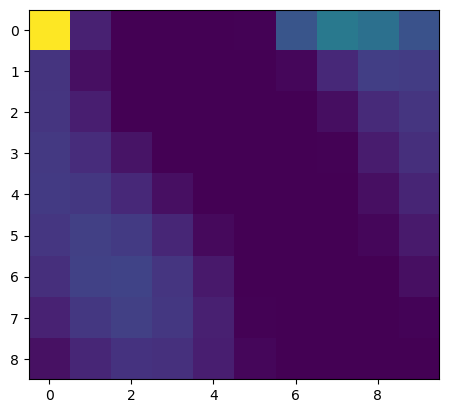

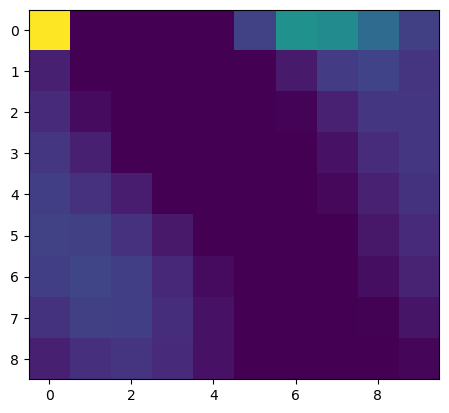

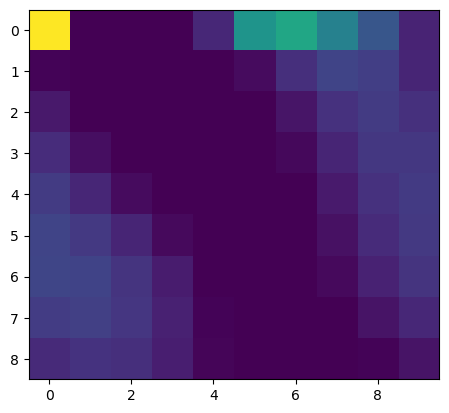

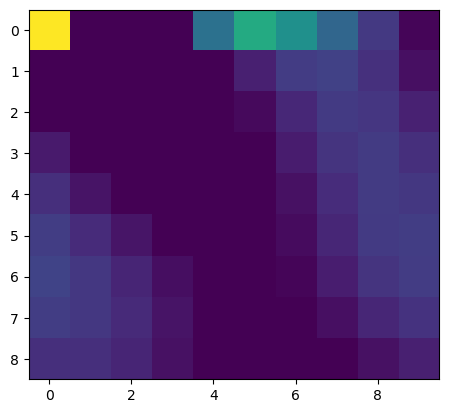

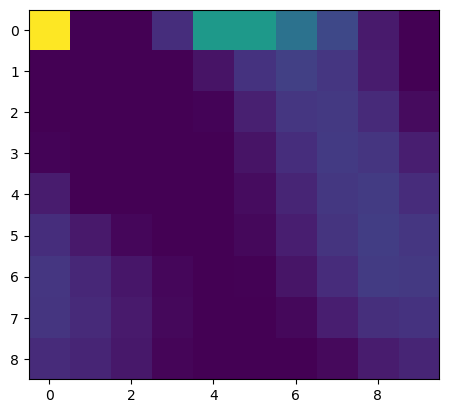

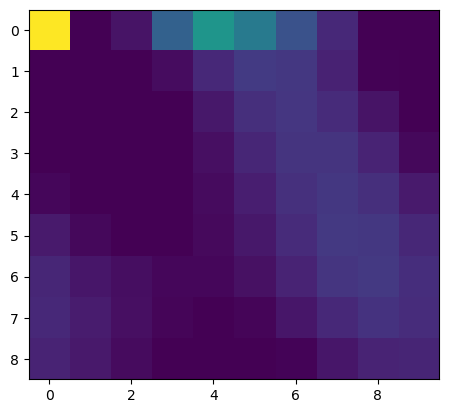

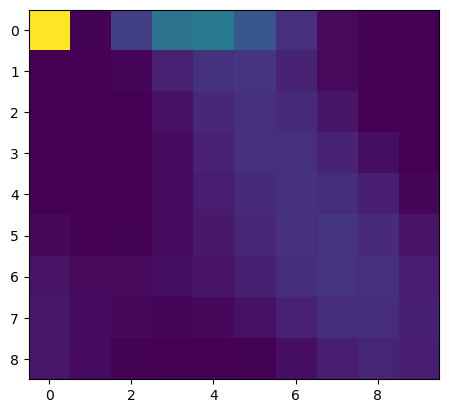

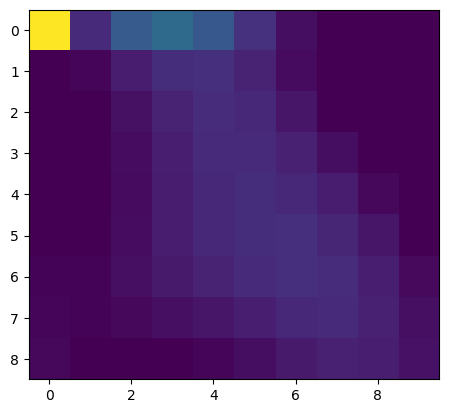

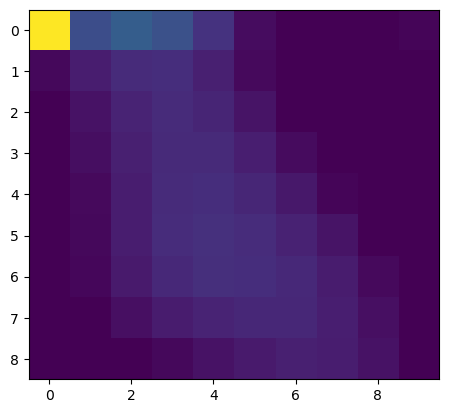

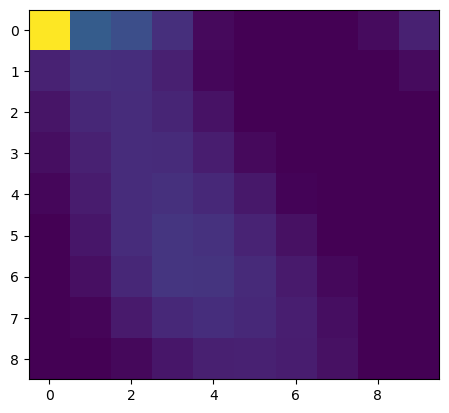

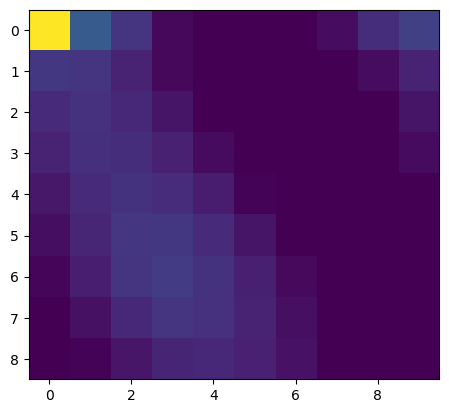

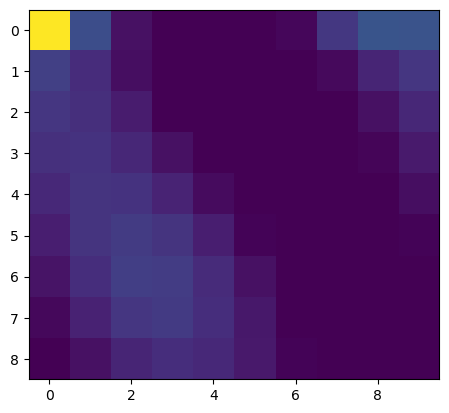

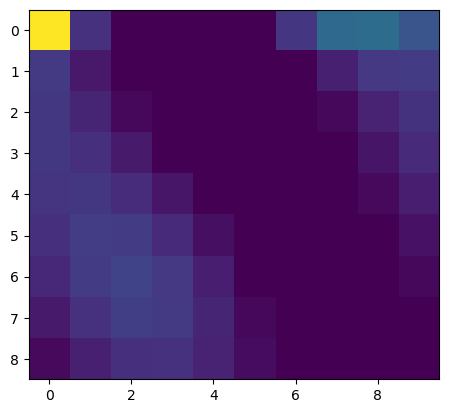

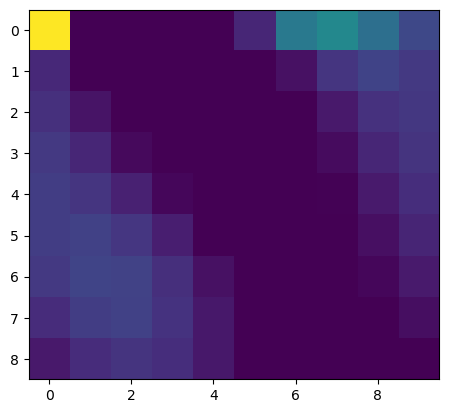

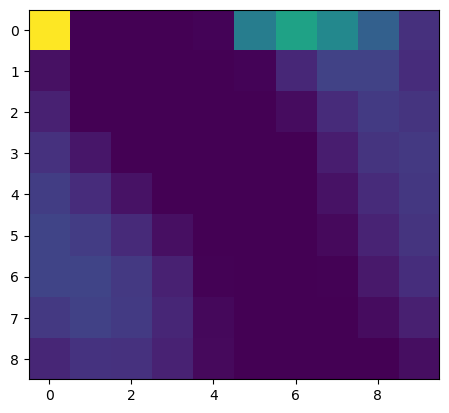

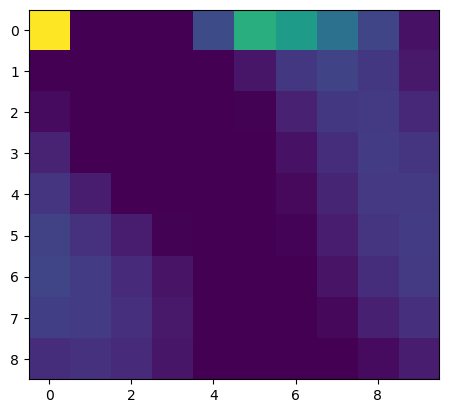

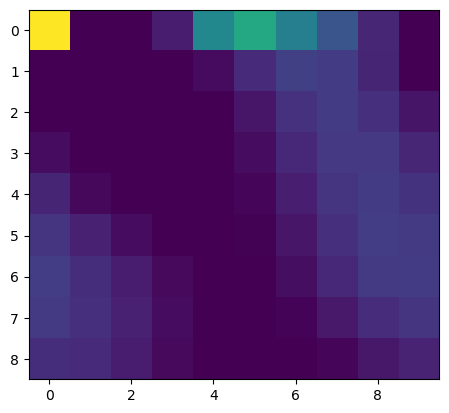

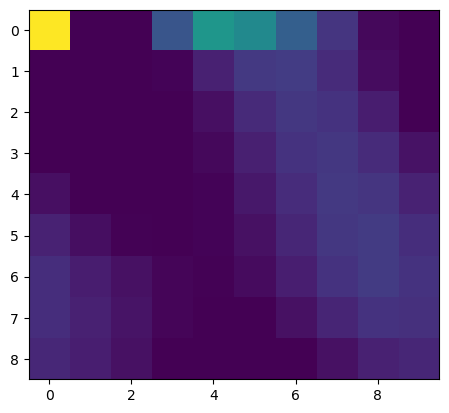

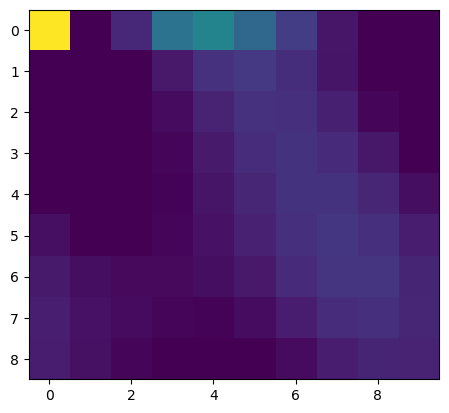

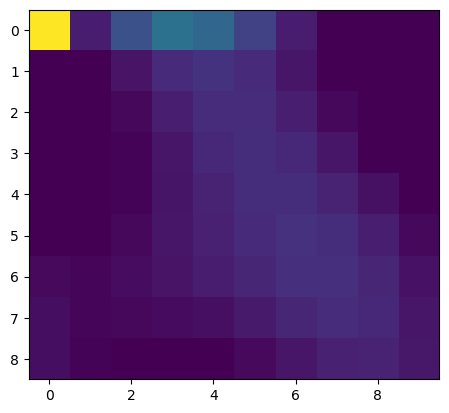

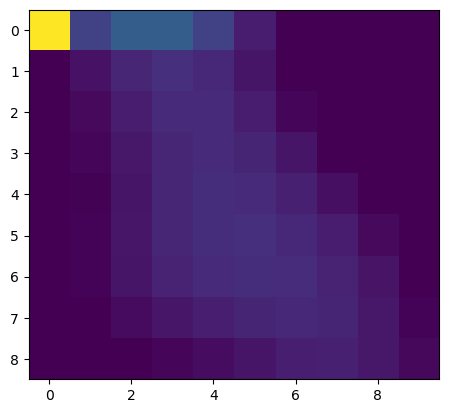

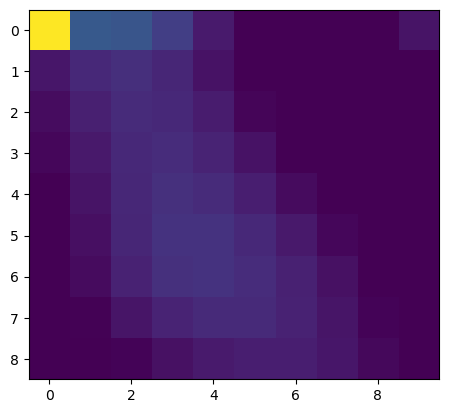

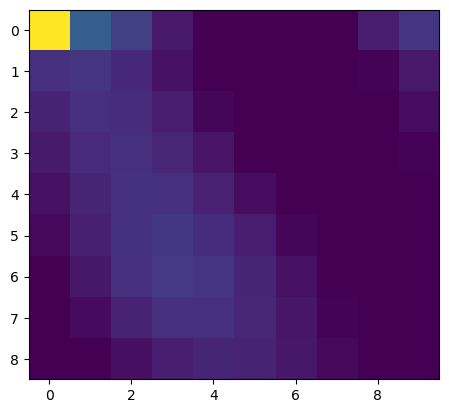

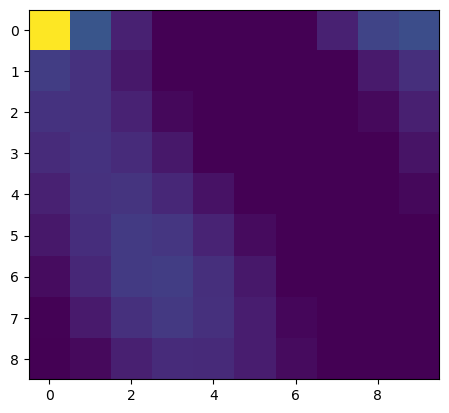

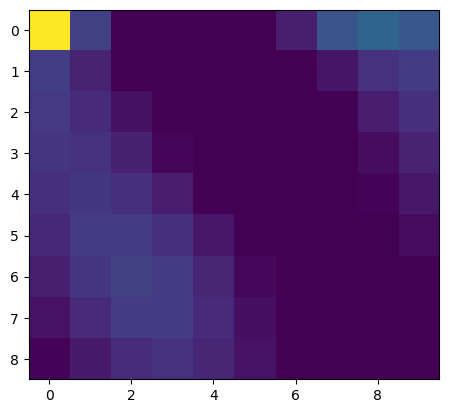

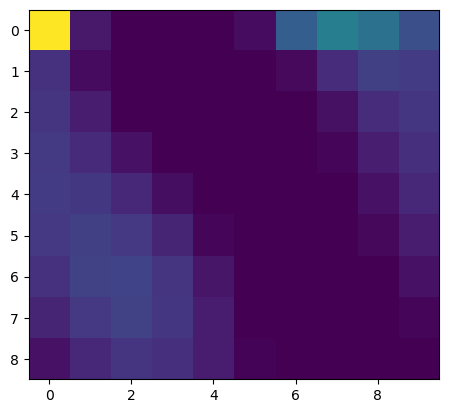

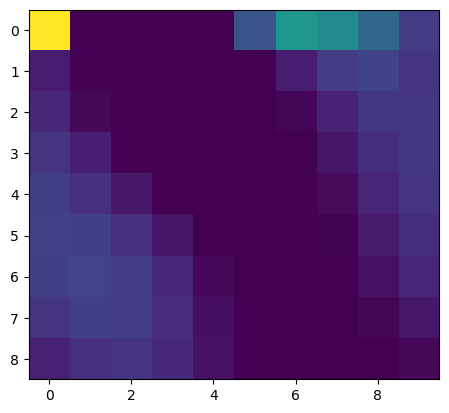

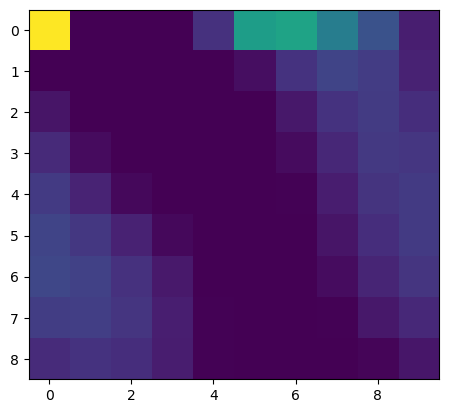

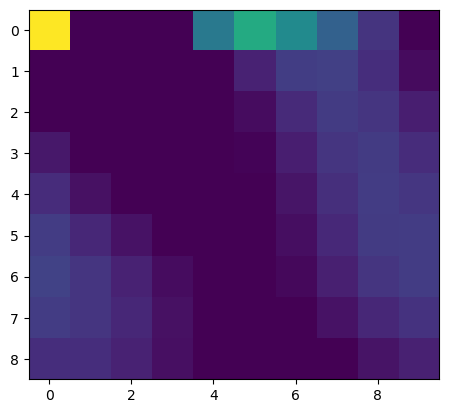

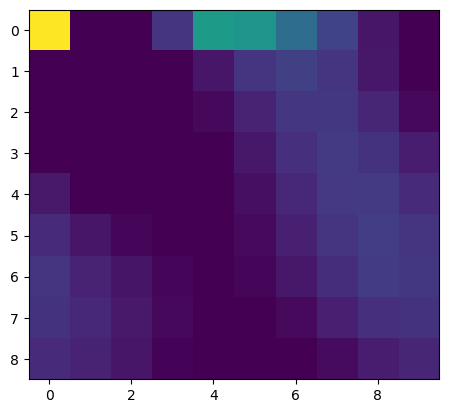

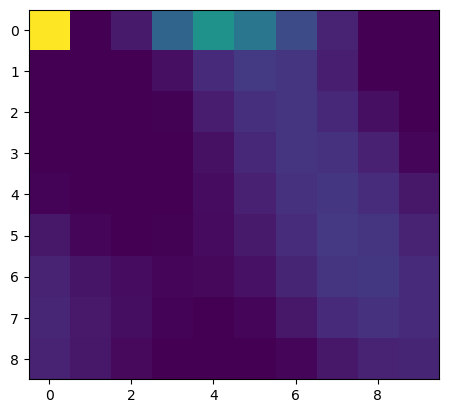

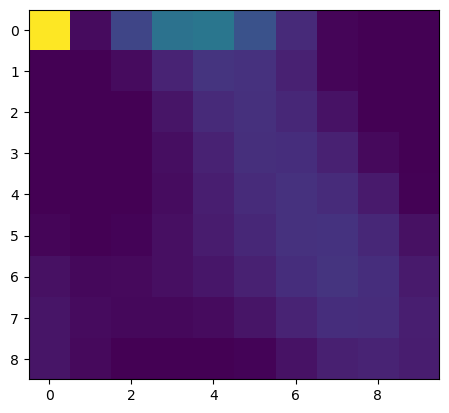

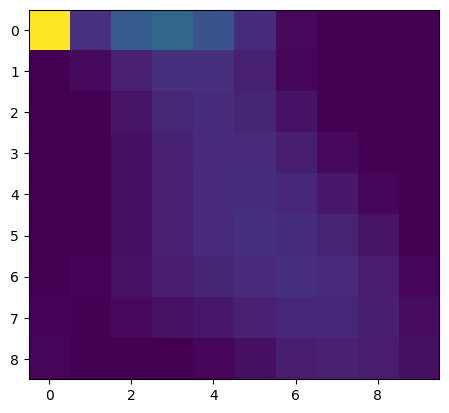

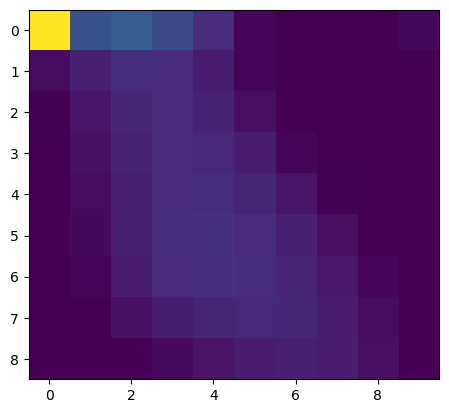

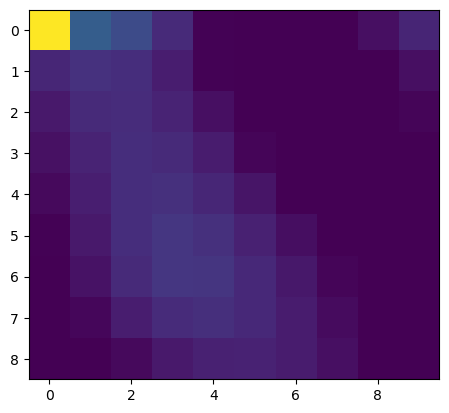

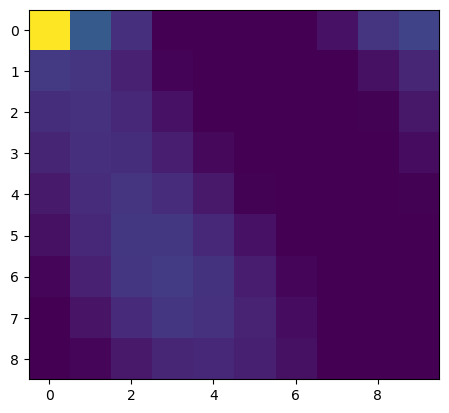

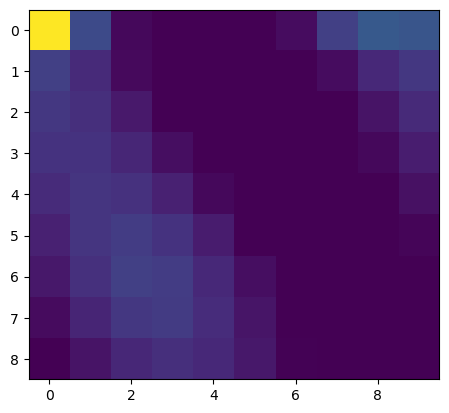

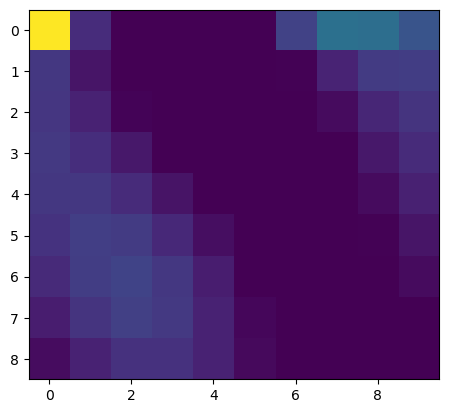

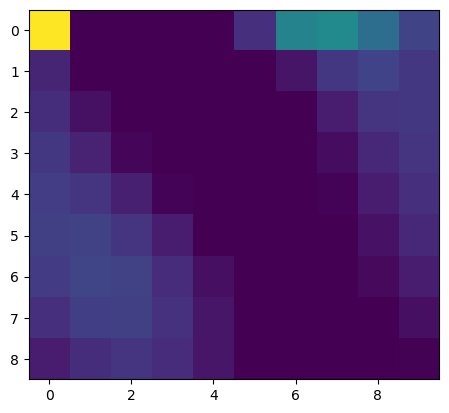

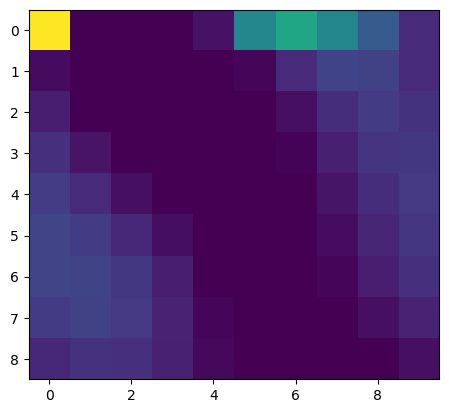

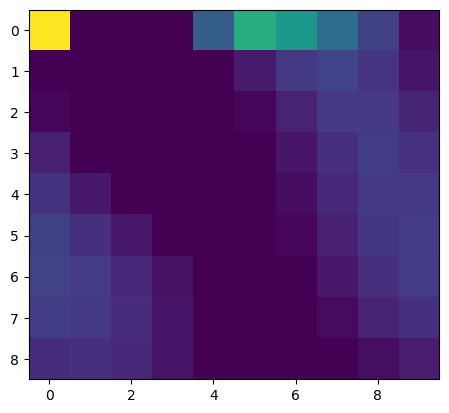

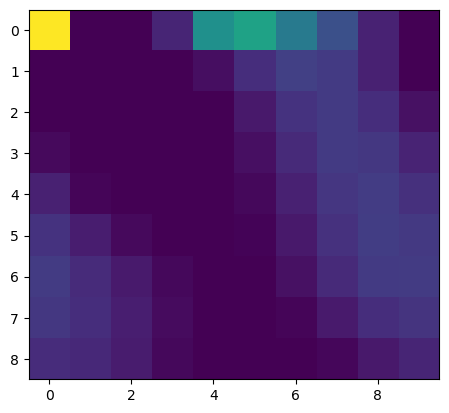

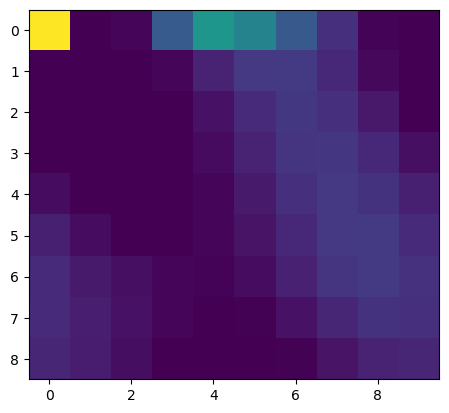

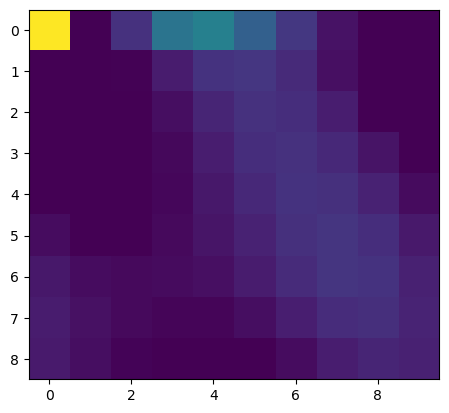

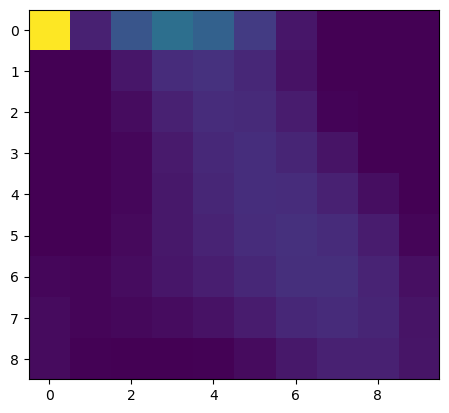

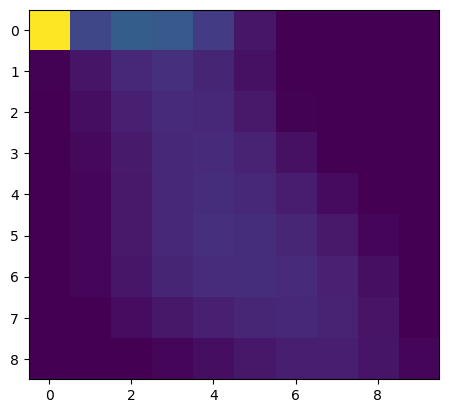

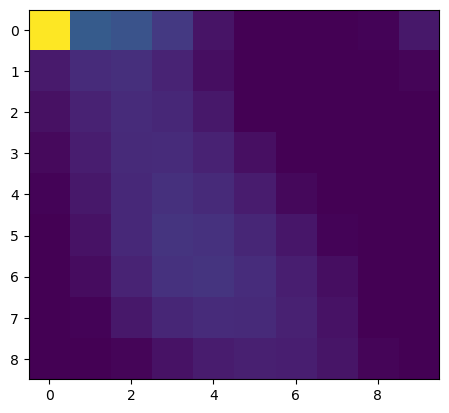

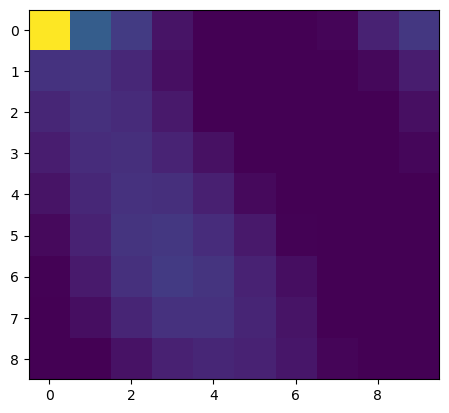

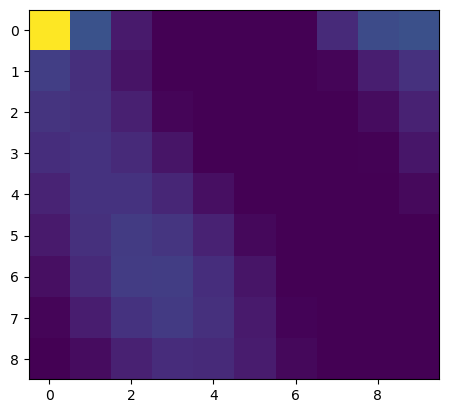

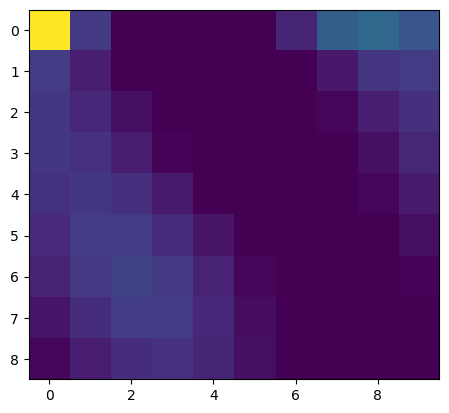

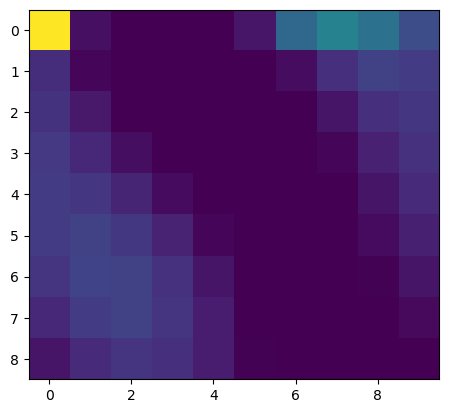

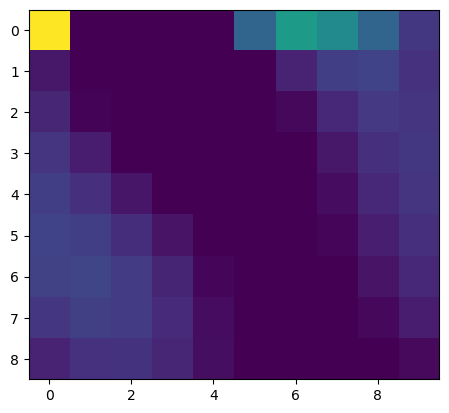

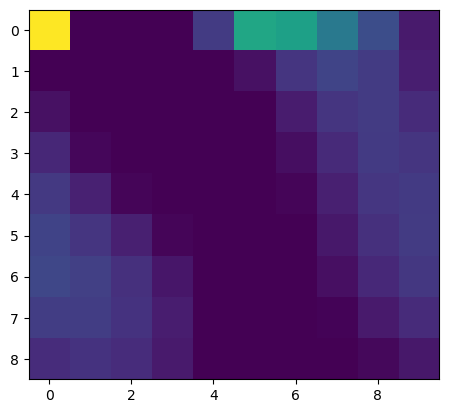

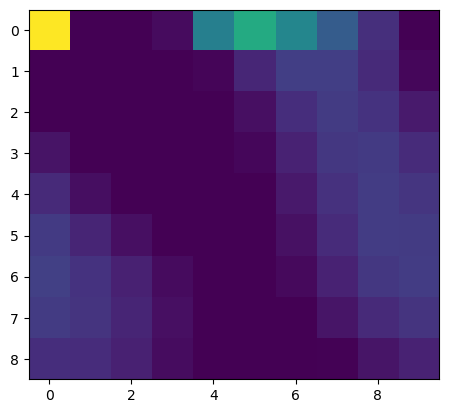

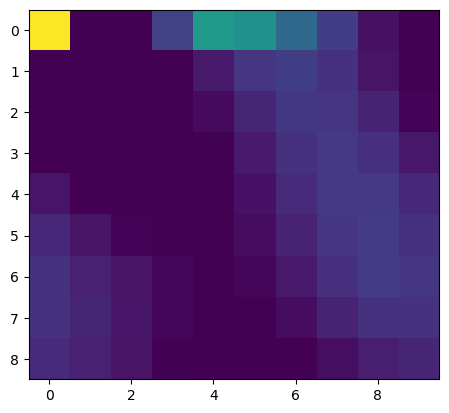

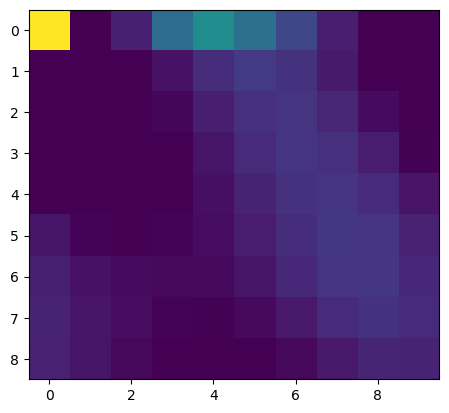

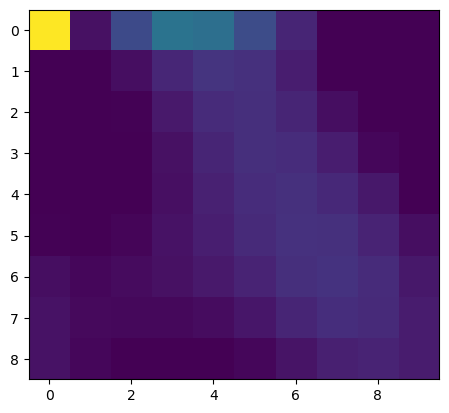

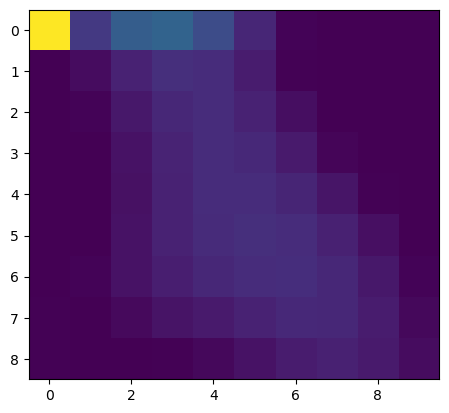

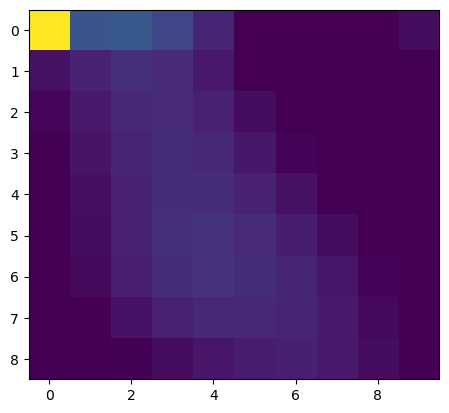

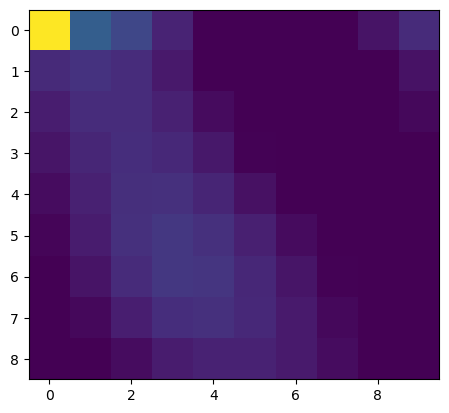

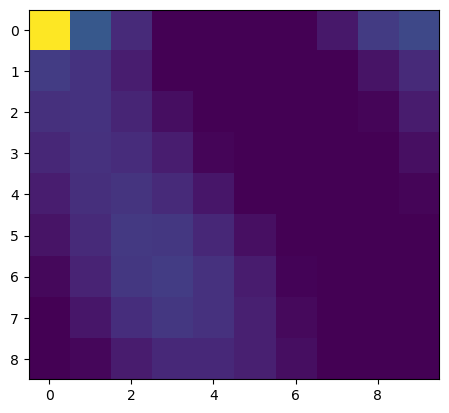

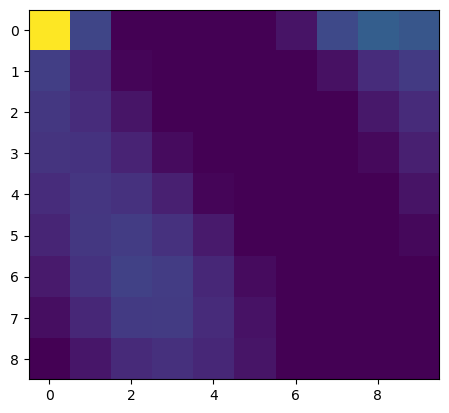

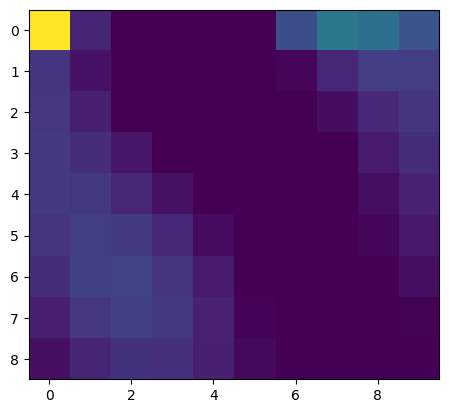

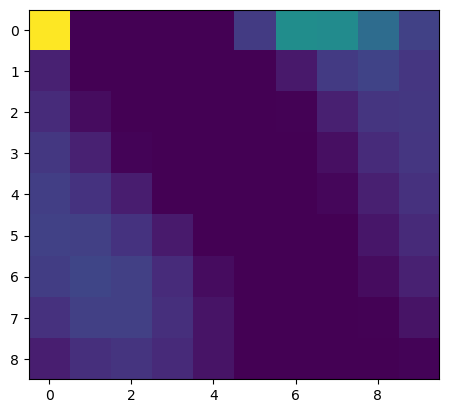

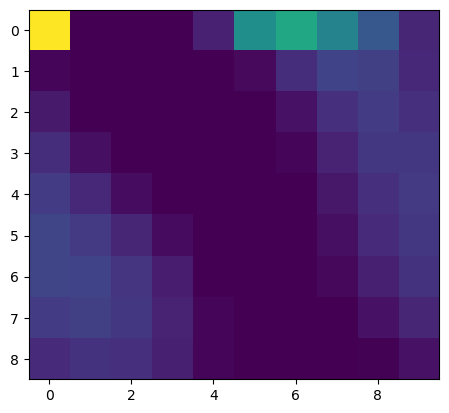

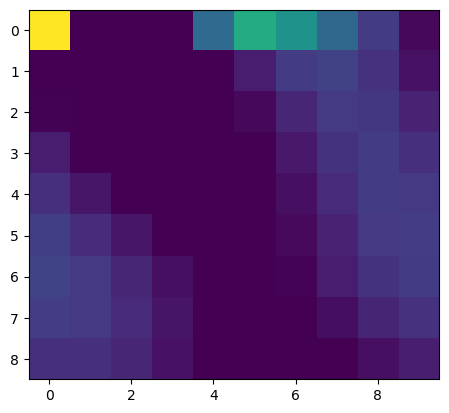

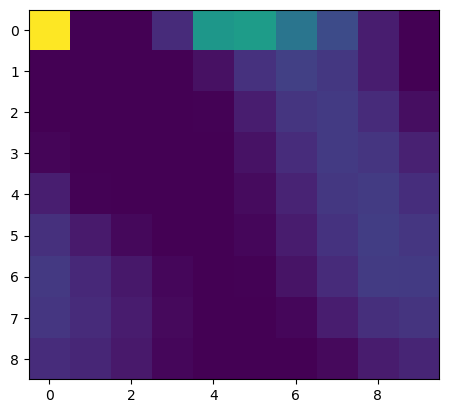

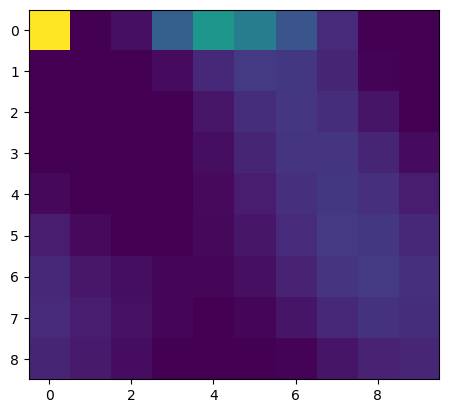

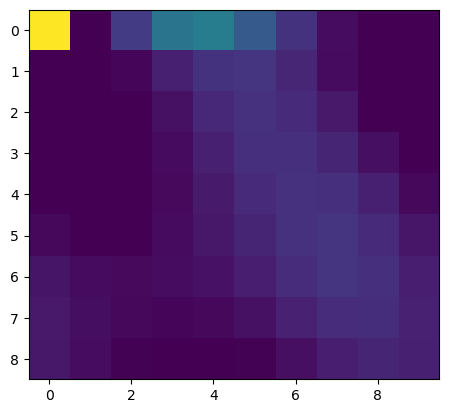

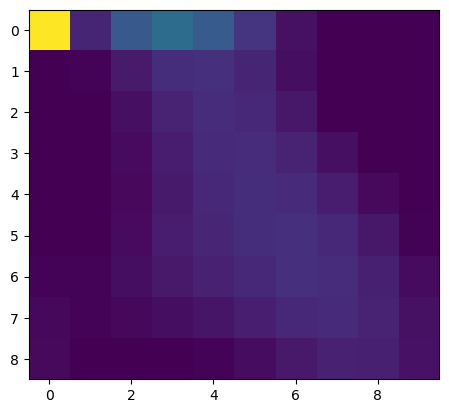

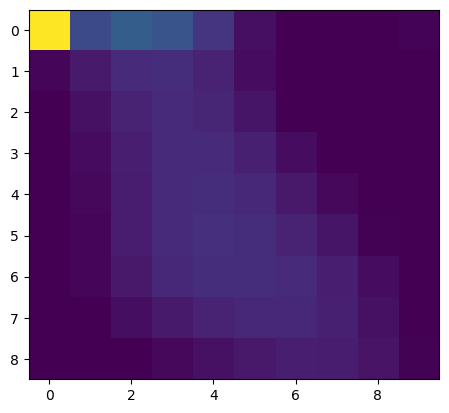

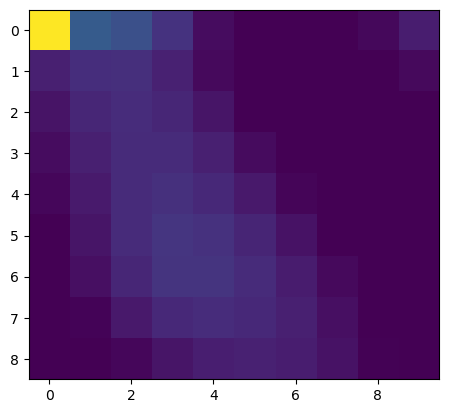

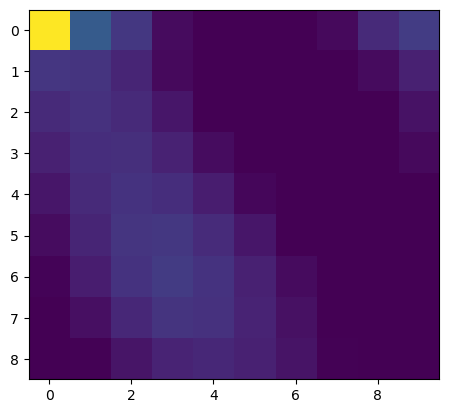

In [20]:
Areshaped = At.reshape(-1,9,10)
for A in Areshaped:
    plt.imshow(A)
    plt.show()

In [24]:

cM = np.cos(beta) + 1j*np.sin(beta)

In [31]:
v1*cM

(-0.9999999999999999+1j)

In [32]:
rM@v2

array([[-1.],
       [ 1.]])

(-2+2j)

In [3]:
class grid_module():
    def __init__(self, Nx ,Ny, gain, bias, I, sigma):
        self.Nx = Nx
        self.Ny = Ny
        self.gain = gain
        self.bias = bias
        self.I = I
        self.sigma = sigma
        self.R = np.cos(bias) + 1j*np.sin(bias)

        #Used to twist the torus
        self.S = [ 0+1j*0, -0.5+1j*np.sqrt(3)/2, -0.5+1j*(-np.sqrt(3)/2), 0.5+1j*np.sqrt(3)/2, 0.5+1j*(-np.sqrt(3)/2), -1+1j*0, 1+1j*0]

        #total number of neurons
        self.N = Nx*Ny
        #Activity Matrix
        self.A = self.init_A()
        #Coord matrix
        self.C = self.init_C()
        #tri distribution
        self.tri = self.dist_tri()
        #Weight matrix
        self.w = self.init_w()
        
    def init_A(self):
        """
        Initializes neuron activity matrix A with random values from 0 to 1/sqrt(N)
        """
        return np.random.uniform(0, 1/np.sqrt(self.N), self.N)

    def init_C(self):
        """
        Initializes neuron coordinate matrix C
        """
        Cx = (np.arange(self.Nx)+(0.5))/self.Nx
        Cy = ((np.arange(self.Ny)+(0.5))/self.Ny)*np.sqrt(3)/2
        Tx, Ty = np.asarray(np.meshgrid(self.Cx, self.Cy))

        return (Tx + 1j*Ty).reshape(-1,1)

    def dist_tri(self):
        """
        Creates distribution
        """
        Ci = (self.C@np.ones_like(self.C.T)).T
        Cj = Ci.T

        D = Ci - Cj

        for s in range(len(self.S)):
            distance = Ci - Cj + s
            idx = np.where(np.abs(distance)<np.abs(D))
            D[idx] = distance[idx]
            
        return D

    def init_w(self):
        """
        Initializes weight matrix
        """
        return self.I * np.exp(-(np.abs(self.tri)**2)/self.sigma**2) - self.T

    def update_w(self, v):
        """
        Updates weight matrix based on velocity
        """
        return self.I * np.exp(-(np.abs(self.tri + self.gain*self.R*v)**2) / self.sigma**2) - self.T

    def B(self):
        """
        B function
        """
        return self.A + self.A@self.w

        

In [25]:
#Total time
T = 1000
#Activity trace
At = np.zeros((T,Ny,Nx))
#Initialize Activity
At[0] = initA(Nx, Ny)

# t = 0
# for A in At:
#     u = 0
#     t+=1
#     for y in A:
#         v = 0
#         u+=1
#         for x in y:
#             v+=1
#             Bt = At[t][u][v] + 

In [28]:
At[0]

array([[0.09097449, 0.00213466, 0.04824029, 0.10033655, 0.04174819,
        0.01321521, 0.03707262, 0.04270762, 0.03799142, 0.09872167],
       [0.10523155, 0.0851333 , 0.04658369, 0.07059163, 0.01177187,
        0.03113697, 0.04381726, 0.07437927, 0.03485283, 0.04474682],
       [0.07182237, 0.01866613, 0.07848858, 0.01107906, 0.00989162,
        0.08411841, 0.00588713, 0.10120159, 0.0377117 , 0.0085701 ],
       [0.02772478, 0.10412534, 0.01035195, 0.00861389, 0.09962828,
        0.04940636, 0.04877016, 0.00579517, 0.04611251, 0.00622513],
       [0.10174544, 0.10384373, 0.00388209, 0.08369128, 0.04063739,
        0.00819655, 0.00685105, 0.05490134, 0.07825399, 0.07833923],
       [0.0567969 , 0.06036354, 0.04520778, 0.0897016 , 0.0846288 ,
        0.08046624, 0.02555999, 0.0041462 , 0.05142996, 0.09541249],
       [0.01195905, 0.07071124, 0.07412817, 0.09110194, 0.04355289,
        0.04124021, 0.07120034, 0.05794961, 0.08444353, 0.10519736],
       [0.09791748, 0.01815966, 0.0611371

In [29]:
At[0][0]

array([0.09097449, 0.00213466, 0.04824029, 0.10033655, 0.04174819,
       0.01321521, 0.03707262, 0.04270762, 0.03799142, 0.09872167])